<a href="https://colab.research.google.com/github/prteek/IO/blob/master/scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This cell is not required to be executed (i.e. ignore any error) if Notebook is run locally or in Binder
# Authorise and mount google drive to access code and data files
import os
from google.colab import drive
drive.mount('/content/drive')
project_folder = '/content/drive/My Drive/git_repos/cv_beginner/document_scanner'

if not(os.path.isdir(project_folder)):
  os.makedirs(project_folder)
  print("new project folder created")

os.chdir(project_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [0]:
# load the image
image = cv2.imread("docs/receipt.jpg")
cv2_imshow(image)

STEP 1: Edge Detection


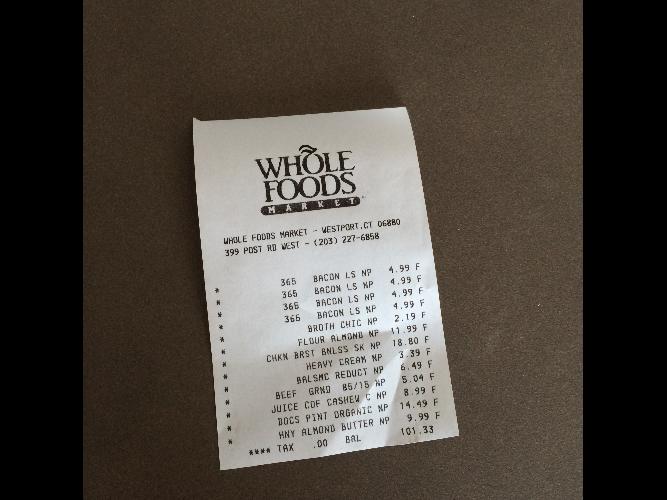

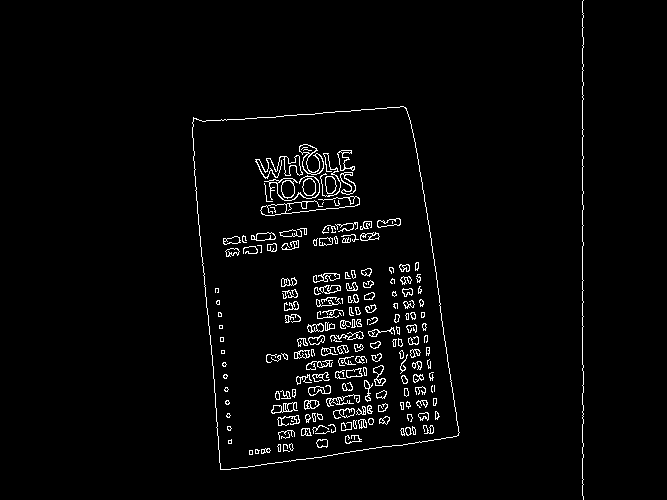

In [0]:
# compute the ratio of the new height
# to the old height, clone it, and resize it

height, width, _ = image.shape
angle            = 90
scale            = 1.0
M = cv2.getRotationMatrix2D((width/2, height/2), angle, scale)
image = cv2.warpAffine(image, M, (width, height)) 

ratio = 500.0/image.shape[0] 
orig  = image.copy()
image = cv2.resize(image, (0,0), fy=ratio, fx=ratio)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
 
# show the original image and the edge detected image
print("STEP 1: Edge Detection")
cv2_imshow(image)
cv2_imshow(edged)


# [**refer**](https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html)

STEP 2: Find contours of paper


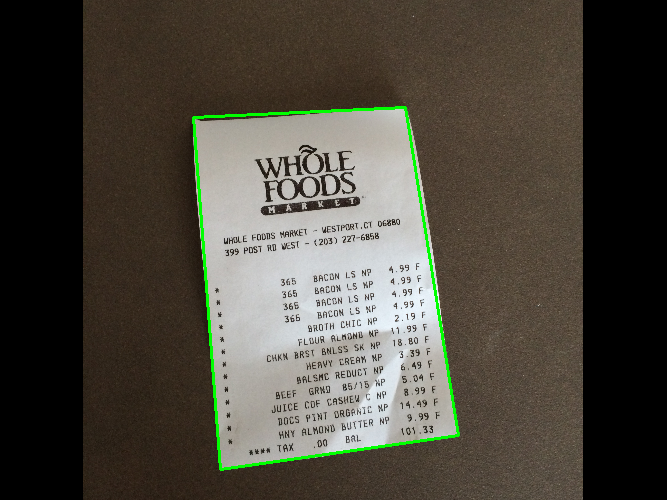

In [0]:
# find the contours in the edged image, keeping only the
# ones with largest area
_,cnts,_   = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts       = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
  # approximate the contour
  peri   = cv2.arcLength(c, True)
  accuracy_of_approximation = 0.02 * peri
  approx = cv2.approxPolyDP(c, accuracy_of_approximation, True) #  Douglas-Peucker algorithm
  # if the approximated contour has four points, then we
	# can assume that we have found our screen
  if len(approx) == 4:
    screenCnt = approx
    break

#  show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2_imshow(image)

In [0]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect

In [0]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
 
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
 
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
 
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
 
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
	# return the warped image
	return warped

STEP 3: Apply perspective transform


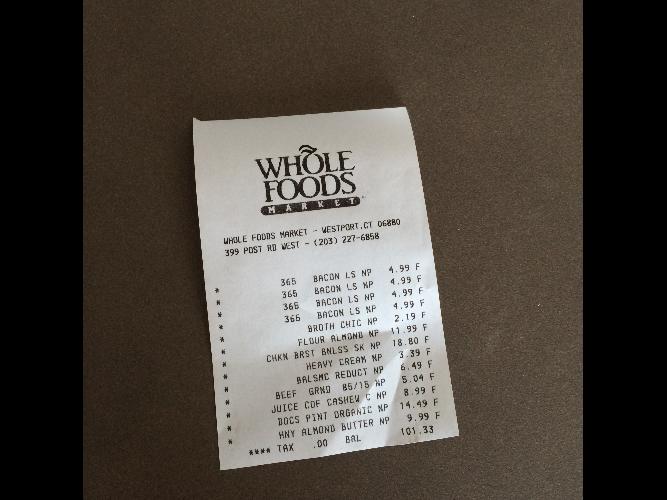

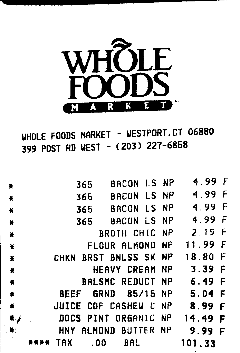

In [0]:
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * 1/ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
_,warped = cv2.threshold(warped, 150, 255, cv2.THRESH_BINARY)

# show the original and scanned images
print("STEP 3: Apply perspective transform")
cv2_imshow(cv2.resize(orig, (0,0), fy=ratio, fx=ratio))
cv2_imshow(cv2.resize(warped, (0,0), fy=ratio, fx=ratio))